**SETUP INSTRUCTIONS**

Run each cell below to set up the environment. Make sure to adjust the subject ID and path variables.
Run pupilLabsDebug BEFORE this program to ensure measurements are as expected.

In [2]:
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subject_id = 3
subj_base = 'plr-90s-sub-003_ses-01_dat-20230712' # plr-ISI-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [ ]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')

Light engine is now set up, and so it is now possible to access the methods from the REST API. 

In [ ]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [ ]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

In [ ]:
from pyplr import stlab

#50mW spec - retrieved from examples/pfr/stimuli/PLR-3000-50-mw.dsf
white_spec = [176, 184, 80, 0, 0, 0, 308, 122, 0, 0]
d.turn_off()

In [ ]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

In [ ]:
# PIPR STIMS - USE THIS ONE
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 85 # interstimulus time, in seconds (actual ISI = this variable + 5 due to sleep)
num_trials = 3 # total number of trials
run_time = ISI*num_trials + 5*num_trials + 30 # appropriate offset to account for stim duration + sleeps


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
i = 0
# random.shuffle(led_list) # use this if stims should be randomized
while (i < num_trials):
    intensities = white_spec
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    i+=1
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data = unpack_data_pandas(pgr_future.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax = data['diameter_3d'].plot()
ax.axvline(x=timestamp, color='k')

In [ ]:
data = unpack_data_pandas(pgr_future.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax = data['diameter_3d'].plot()
ax.axvline(x=timestamp, color='k')
# display data from pandas table
data

In [ ]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data.to_csv(path_base + subj_base + '.csv') # raw data

**DATA PROCESSING BEGINS BELOW**

In [ ]:
samples = data
samples

In [ ]:
from pyplr import graphing
from pyplr import preproc
import matplotlib.pyplot as plt

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [ ]:
# export butterworth processed sample data (?)
samples.to_csv(path_base + subj_base + '-butterworth.csv') # raw data
# stop here, run second protocol

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
# df_pipr = samples # this is the smoothed out data
df_pipr = pd.read_csv(path_base + subj_base + '-butterworth.csv')

# Print header names
print(df_pipr.columns)

# Extract the column with header "timestamp"
timestamps = df_pipr["timestamp"]
# Extract the column with header "diameter_3d"
diam_3d = df_pipr["diameter_3d"]

Index(['timestamp', 'id', 'topic', 'method', 'norm_pos', 'diameter',
       'confidence', 'sphere', 'projected_sphere', 'circle_3d', 'diameter_3d',
       'ellipse', 'location', 'model_confidence', 'theta', 'phi',
       'interpolated'],
      dtype='object')


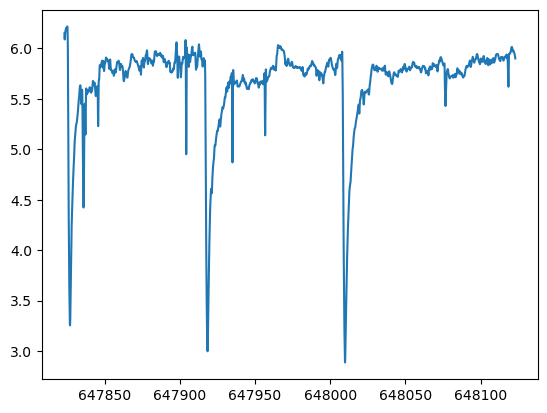

In [5]:
fig = plt.figure()
plt.plot(timestamps, diam_3d) # this should be the smoothed out data - if not, check

This is copied from the output of cell 11
> Light stamped on frame.world at 647825.189762
> Waiting for a light to stamp...
> Light stamped on frame.world at 647916.6697170001
> Waiting for a light to stamp...
> Light stamped on frame.world at 648008.0312750001

**Edit Cell Below with Timestamps**

In [6]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps <= 647825.189762)[0][-1]
stamp2 = np.where(timestamps <= 647916.6697170001)[0][-1]
stamp3 = np.where(timestamps <= 648008.0312750001)[0][-1]
stamps = [stamp1, stamp2, stamp3]
stamps

[108, 4042, 8273]

In [7]:
from pyplr import utils
from copy import deepcopy

In [8]:
df_data = df_pipr[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data

,timestamp,confidence,id,diameter,diameter_3d
0,647823.124082,0.926415,1,66.482073,6.149651
1,647823.146329,0.916072,1,66.397823,6.140048
2,647823.168716,0.873511,1,66.318155,6.130894
3,647823.181453,0.913552,1,66.244379,6.122308
4,647823.199158,0.905227,1,66.177833,6.114419
...,...,...,...,...,...
13203,648122.964620,0.911211,1,66.304490,5.917685
13204,648123.009704,0.908449,1,66.256494,5.913200
13205,648123.056606,0.901373,1,66.208849,5.908742
13206,648123.100734,0.874364,1,66.162628,5.904414


In [9]:
# extract ranges from samples based on event timing and sample count
# adapted from extract() from utils.py
# set variables - change as necessary
samples = df_data
event_starts = stamps 
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs = (
    np.searchsorted(samples.index, event_starts, "left") + offset
)
range_duration = duration


In [10]:
range_idxs

array([  48, 3982, 8213], dtype=int64)

In [11]:
# make a hierarchical index
samples["orig_idx"] = samples.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples):
        end_idx = len(samples) - 1
    new_df = deepcopy(
        samples.loc[samples.index[start_idx] : samples.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df = pd.concat([df, new_df])
    idx += 1
df.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

Extracted ranges for 3 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_21024\2016008756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["orig_idx"] = samples.index


In [12]:
df.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (2, 3590),
            (2, 3591),
            (2, 3592),
            (2, 3593),
            (2, 3594),
            (2, 3595),
            (2, 3596),
            (2, 3597),
            (2, 3598),
            (2, 3599)],
           names=['event', 'onset'], length=10800)

In [13]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines = df.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df = preproc.percent_signal_change(
    df, baselines, ['diameter_3d', 'diameter'])
df


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_21024\2404135914.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines = df.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      647824.071364    0.980713   1  66.834537     6.191821        48   
      1      647824.093377    0.940498   1  66.848676     6.193457        49   
      2      647824.111456    0.977985   1  66.863090     6.195019        50   
      3      647824.130408    0.984526   1  66.877551     6.196496        51   
      4      647824.145209    0.961331   1  66.891827     6.197876        52   
...                    ...         ...  ..        ...          ...       ...   
2     3595   648090.054599    1.000000   1  65.116734     5.797129     11808   
      3596   648090.074159    1.000000   1  65.115502     5.797640     11809   
      3597   648090.099703    1.000000   1  65.114241     5.798212     11810   
      3598   648090.122398    0.991815   1  65.113373     5.798874     11811   
      3599   648090.141210    0.983031   1  65.113274     5.799645     11812   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.143388    -0.099328  
      1           -0.117003    -0.078192  
      2           -0.091805    -0.056648  
      3           -0.067988    -0.035032  
      4           -0.045738    -0.013694  
...                     ...          ...  
2     3595        -1.871849    -2.287587  
      3596        -1.863196    -2.289435  
      3597        -1.853516    -2.291329  
      3598        -1.842323    -2.292631  
      3599        -1.829272    -2.292780  

[10800 rows x 8 columns]

In [14]:
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_21024\2953176601.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  average_plr = df.mean(level=1)['diameter_3d'].to_numpy()


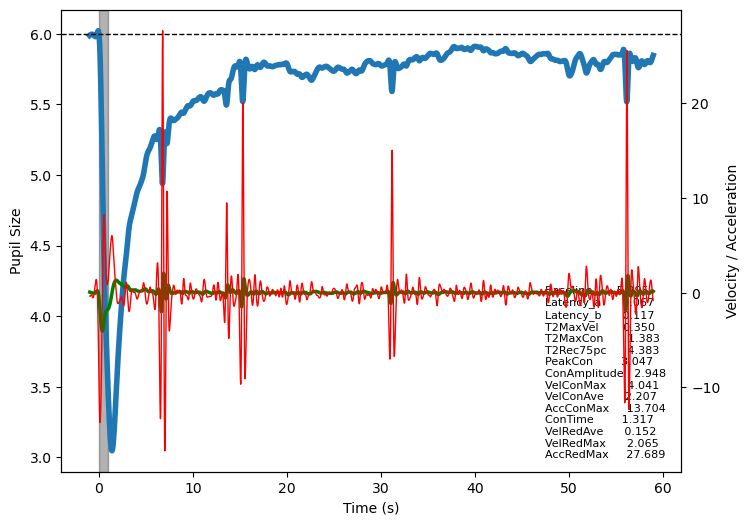

In [17]:
fig = plr.plot(vel=True, acc=True, print_params=True)
import os
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + subj_base + '.png')

In [ ]:
params = plr.parameters()
params

In [ ]:
df.to_csv(path_base + subj_base + '-processed.csv') # processed data with adjusted onset indices (time in seconds)

In [ ]:
param_new=params.transpose()
param_new.reset_index(drop=True)

In [ ]:
param_new["subject_id"] = subject_id
param_new = param_new.set_index("subject_id")
param_new.to_csv(path_base + subj_base + '-plr-params.csv') # pupillary light response calculated parameters
param_new.to_csv(path_base + 'plr-90s-params.csv') # initiate new database with all subject data (REMOVE FOR OTHER FILES)